In [3]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("/home/postdoc/dsen/Desktop/Biometrika-code/mbsampler.jl")
include("temp.jl")

plot_acfs_all (generic function with 2 methods)

In [4]:
mb_size = 50
dim  = 50
Nobs_list = [500]
pX_list = [1.]
attempts = [10^8]
cov_dist = "uniform"
n_reps = 1
varying = "Nobs"
include_CV, include_stratified = true, false
prior_sigma = 1e0
adapt_speed = "by_var";

In [10]:
start = time()
for rep in 1:n_reps 
    for i in 1:length(Nobs_list) 
        my_model, root = generate_model(dim, Nobs_list[i], pX_list[i], cov_dist, prior_sigma) 
        run_mbsamplers(my_model, root, mb_size, attempts[i], pX_list[i], Nobs_list[i], 
                       varying, rep, cov_dist, include_CV, include_stratified, adapt_speed)
    end
end
print("\n Total time = ", round((time()-start)/60,2), " mins")

Rep = 1; Nobs = 500; stratified, CV, weighted = false true true; time = 259.2 min 
Rep = 1; Nobs = 500; stratified, CV, weighted = false false true; time = 244.75 min 

 Total time = 503.96 mins

In [37]:
attempts = [10^7]
dim = 10
start = time()
for rep in 1:n_reps 
    for i in 1:length(Nobs_list) 
        my_model, root = generate_model(dim, Nobs_list[i], pX_list[i], cov_dist, prior_sigma) 
        run_mbsamplers(my_model, root, mb_size, attempts[i], pX_list[i], Nobs_list[i], 
                       varying, rep, cov_dist, include_CV, include_stratified, adapt_speed)
    end
end
print("\n Total time = ", round((time()-start)/60,2), " mins")

Rep = 1; Nobs = 500; stratified, CV, weighted = false true true; time = 22.78 min 
Rep = 1; Nobs = 500; stratified, CV, weighted = false false true; time = 21.48 min 

 Total time = 44.27 mins

#### Read data and make plots:

In [3]:
skels = fill(randn(1,1),2,3)
bts = fill(randn(1,1),2,3);

In [9]:
dim = 10
weighted, stratified = true, false

cov_dists = ["Laplace", "Gaussian", "uniform"]
subfolder = "scaling_Nobs"

Nobs_list = [500]
@showprogress for rep in 1:n_reps
    for (i,Nobs) in enumerate(Nobs_list) 
        for CV in [true,false] 
            for (j,cov_dist) in enumerate(cov_dists)
                for (k,d) in enumerate([dim])
                    filename = "/xtmp/PDMP_data_revision/"*subfolder*"/cov_dist:"*cov_dist*"-Nobs:"*
                                string(Nobs)*"-rep:"*string(rep)*"-stratified:"*string(stratified)*
                                "-CV:"*string(CV)*"-weighted:"*string(weighted)*"-d:"*string(d)*".jld"
                    skels[1+CV,j], bts[1+CV,j] = load(filename, "xt_skeleton", "bt_skeleton")
                end
            end
        end
    end
end

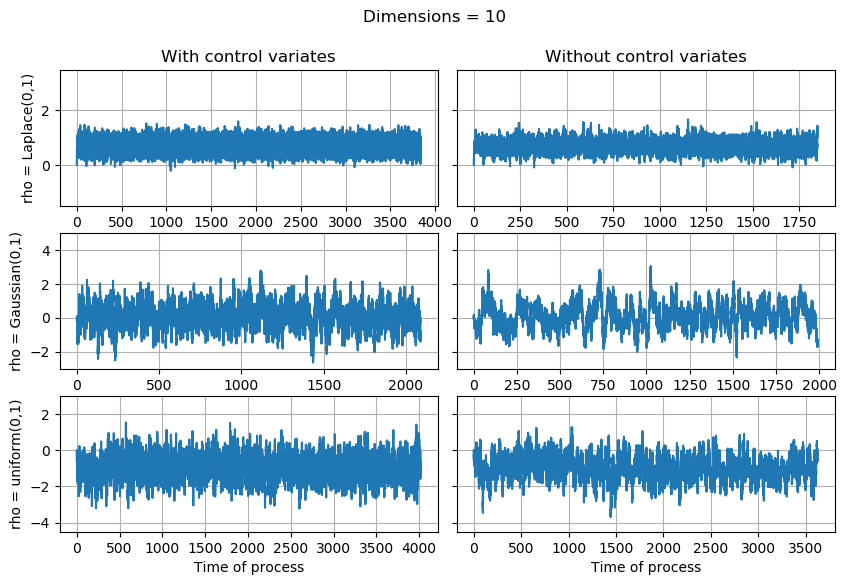

In [11]:
dd = 1
cov_dists = ["Laplace", "Gaussian", "uniform"]
fig = figure("pyplot_subplot_mixed", figsize=(10,6))
for (j,cov_dist) in enumerate(cov_dists)
    subplot(length(cov_dists),2,2*(j-1)+1)
    CV = true
    plot(bts[1+CV,j][1,:], skels[1+CV,j][dd,:])
    if j == 1 title("With control variates") end
    if j == length(cov_dists) xlabel("Time of process") end
    grid(true)
    if j == 1 
        ylim(-1.5,3.5)
    elseif j == 2
        ylim(-3,5)
    elseif j == 3
        ylim(-4.5,3)
    end
    ylabel("rho = "*cov_dist*"(0,1)")
    
    subplot(length(cov_dists),2,2*(j-1)+2)
    CV = false
    plot(bts[1+CV,j][1,:], skels[1+CV,j][dd,:])
    if j == 1 title("Without control variates") end
    if j == length(cov_dists) xlabel("Time of process") end
    if j == 1 
        ylim(-1.5,3.5)
    elseif j == 2
        ylim(-3,5)
    elseif j == 3
        ylim(-4.5,3)
    end
    grid(true)
    yticks(alpha=0)
    
end
subplots_adjust(wspace=0.05)
suptitle("Dimensions = "*string(dim));

In [9]:
cov_dists = ["Laplace", "Gaussian", "uniform"]
subfolder = "scaling_Nobs"
dim = 10
weighted, stratified = true, false
acfs_toplot = fill(rand(2,2),2,3,2)
xt = []
n_samples = 10^5
maxlag = 500

rep = 1
Nobs = Nobs_list[1]

for CV in [true,false] 
    for (j,cov_dist) in enumerate(cov_dists)
        for (k,d) in enumerate([10,50])
            filename = "/xtmp/PDMP_data_revision/"*subfolder*"/cov_dist:"*cov_dist*"-Nobs:"*
                        string(Nobs)*"-rep:"*string(rep)*"-stratified:"*string(stratified)*
                        "-CV:"*string(CV)*"-weighted:"*string(weighted)*"-d:"*string(d)*".jld"
            skel, bt = load(filename, "xt_skeleton", "bt_skeleton")
            samples = extract_samples(skel, bt, bt[end]/n_samples) 
            a = zeros(d,maxlag+1)
            for i in 1:d 
                a[i,:] = acf(samples[i,:],maxlag)
            end
            acfs_toplot[1+CV,j,k] = a
        end
    end
end

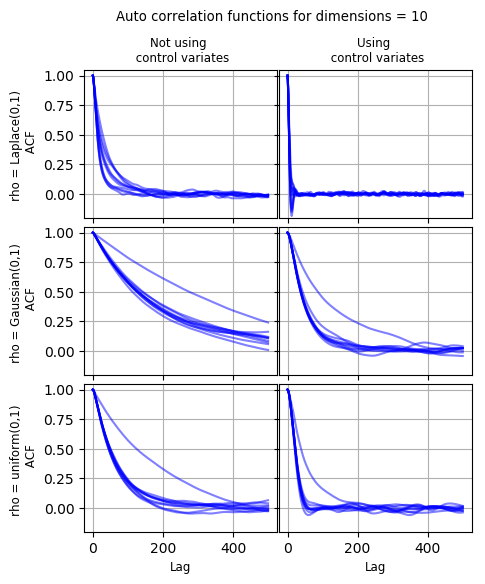

In [19]:
k = 1
d = 10
yt = [0,0.25,0.5,0.75,1]
fig = figure("pyplot_subplot_mixed", figsize=(5,6))
for (j,cov_dist) in enumerate(cov_dists)
    for CV in [false,true] 
        subplot(length(cov_dists), 2, 2*(j-1)+CV+1)
        for i in 1:d 
            plot(acfs_toplot[1+CV,j,k][i,:], color="blue", alpha=0.5)
        end
        if j == 1 
            if CV 
                title("Using \n control variates", fontsize=8.5) 
            else 
                title("Not using \n control variates", fontsize=8.5) 
            end
        end
        grid(true)
        if j < length(cov_dists) xticks(alpha=0) end
        if !CV ylabel("rho = "*cov_dists[j]*"(0,1) \n ACF", fontsize=8.5) end
        if CV yticks(yt, alpha=0) end
        if j == length(cov_dists) xlabel("Lag", fontsize=8.5) end
        ylim(-0.2,1.05)
    end
end
subplots_adjust(wspace=0.01,hspace=0.06)
suptitle("Auto correlation functions for dimensions = "*string(d), fontsize=9.5)
savefig("/home/postdoc/dsen/Desktop/Biometrika-code/plots/acfs_dense_d10.pdf", 
    format="pdf", dpi=10000, bbox_inches="tight");

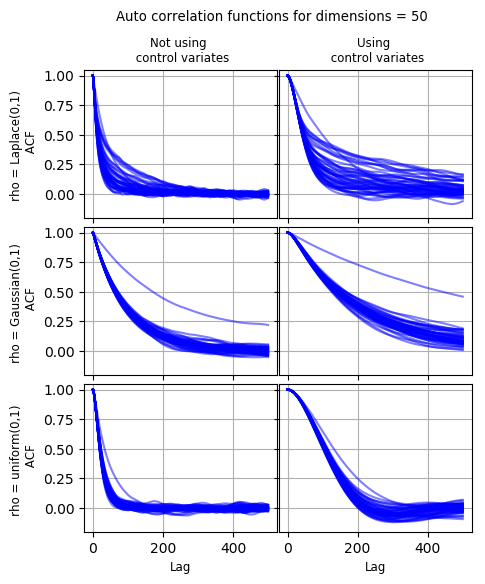

In [20]:
k = 2
d = 50
yt = [0,0.25,0.5,0.75,1]
fig = figure("pyplot_subplot_mixed", figsize=(5,6))
for (j,cov_dist) in enumerate(cov_dists)
    for CV in [false,true] 
        subplot(length(cov_dists), 2, 2*(j-1)+CV+1)
        for i in 1:d 
            plot(acfs_toplot[1+CV,j,k][i,:], color="blue", alpha=0.5)
        end
        if j == 1 
            if CV 
                title("Using \n control variates", fontsize=8.5) 
            else 
                title("Not using \n control variates", fontsize=8.5) 
            end
        end
        grid(true)
        if j < length(cov_dists) xticks(alpha=0) end
        if !CV ylabel("rho = "*cov_dists[j]*"(0,1) \n ACF", fontsize=8.5) end
        if CV yticks(yt, alpha=0) end
        if j == length(cov_dists) xlabel("Lag", fontsize=8.5) end
        ylim(-0.2,1.05)
    end
end
subplots_adjust(wspace=0.01,hspace=0.06)
suptitle("Auto correlation functions for dimensions = "*string(d), fontsize=9.5)
savefig("/home/postdoc/dsen/Desktop/Biometrika-code/plots/acfs_dense_d50.pdf", 
    format="pdf", dpi=10000, bbox_inches="tight");